# U2AF1 mutaitons merging and post processing

In [2]:
import pandas as pd
import gzip
import os
from io import StringIO
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import seaborn as sns
import numpy as np

## 1. Merge files

In [ ]:
# List files in directory
files = os.listdir('/mnt/project/analysis/output/U2AF1/')
files = [file for file in files if file.endswith('output')]

len(files)
files

In [3]:
off_target = ['intron_variant', 'synonymous_variant', '5_prime_UTR_variant', '3_prime_UTR_variant', 'upstream_gene_variant', 'downstream_gene_variant']

Mutect2_tar_var = pd.read_csv('/mnt/project/analysis/output/U2AF1/U2AF1_wnode1.output',sep="\t")
print(len(Mutect2_tar_var))
Mutect2_tar_var = Mutect2_tar_var[~Mutect2_tar_var['Consequence'].isin(off_target)]
print(len(Mutect2_tar_var))


files = ['U2AF1_wnode2.output']

Mutect2_tar_var_df = pd.read_csv('/mnt/project/analysis/output/U2AF1/U2AF1_wnode2.output',sep="\t")
Mutect2_tar_var_df = Mutect2_tar_var_df[~Mutect2_tar_var_df['Consequence'].isin(off_target)]

Mutect2_tar_var = pd.concat([Mutect2_tar_var, Mutect2_tar_var_df], ignore_index=True)
len(Mutect2_tar_var)

137790
124974


249676

In [4]:
Mutect2_tar_var['case'] = [x.split('/')[-1].split('_')[0] for x in list(Mutect2_tar_var['name_file'])]
len(set(Mutect2_tar_var['case']))

216531

## 2. Remove cases with empty mutaitons

In [5]:
#Cases without mutations are annotated as headers..!!!!
Mutect2_tar_var = Mutect2_tar_var[Mutect2_tar_var['Consequence']!= 'Consequence']
Mutect2_tar_var = Mutect2_tar_var[Mutect2_tar_var['gnomAD_AF']!= 'gnomAD_AF']
len(Mutect2_tar_var)

249588

In [6]:
# No germline included in 1000Genomes
Mutect2_tar_var.EUR_AF.value_counts()

0    63
Name: EUR_AF, dtype: int64

In [7]:
Mutect2_tar_var = Mutect2_tar_var.rename(columns={'#CHROM_x': '#CHROM', 'POS_x': 'POS', 'ID_x':'ID', 'REF_x':'REF', 'QUAL_x': 'QUAL', 'FILTER_x': 'FILTER'})
Mutect2_tar_var.columns

Index(['name_file', '#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER',
       'VEP', 'AD_alt', 'DP', 'VAF_alt', 'ADF_alt', 'ADR_alt', 'VEP_cano',
       'Consequence', 'IMPACT', 'SYMBOL', 'ENST', 'CDS_pos', 'Prot_pos',
       'AA_change', 'rs_ID', 'ENSP', 'EUR_AF', 'gnomAD_AF', 'gnomAD_AF_NFE',
       'case'],
      dtype='object')

In [1]:
# Replace germline info: NaN for 0
Mutect2_tar_var[Mutect2_tar_var['gnomAD_AF'].replace(np.nan, 0).astype(float)>0]

## 3. Remove germline

In [11]:
# Perform germline filtering

print(len(Mutect2_tar_var))
Mutect2_tar_var['gnomAD_AF'] = Mutect2_tar_var['gnomAD_AF'].replace(' ', 0).astype(float)
Mutect2_tar_var['gnomAD_AF_NFE'] = Mutect2_tar_var['gnomAD_AF_NFE'].replace(' ', 0).astype(float)
Mutect2_tar_var['EUR_AF'] = Mutect2_tar_var['EUR_AF'].replace(' ', 0).astype(float)
Mutect2_tar_var['gnomAD_AF'] = Mutect2_tar_var['gnomAD_AF'].replace(np.nan, 0).astype(float)
Mutect2_tar_var['gnomAD_AF_NFE'] = Mutect2_tar_var['gnomAD_AF_NFE'].replace(np.nan, 0).astype(float)
Mutect2_tar_var['EUR_AF'] = Mutect2_tar_var['EUR_AF'].replace(np.nan, 0).astype(float)

maf_can_VAF_SNP = Mutect2_tar_var[(Mutect2_tar_var['gnomAD_AF']>=0.001) |\
                                     (Mutect2_tar_var['gnomAD_AF_NFE']>=0.001) |\
                                     (Mutect2_tar_var['EUR_AF']>=0.001)]
print(len(maf_can_VAF_SNP))
# maf_VAF.drop(maf_can_VAF_SNP.index.values.tolist(), axis=0)
maf_can_VAF_SNV = Mutect2_tar_var[(Mutect2_tar_var['gnomAD_AF']<=0.001) &\
                                     (Mutect2_tar_var['gnomAD_AF_NFE']<=0.001) &\
                                     (Mutect2_tar_var['EUR_AF']<=0.001)]
print(len(maf_can_VAF_SNV))

249588
0
249588


In [12]:
maf_can_VAF_SNV.Consequence.value_counts()

missense_variant                            249043
stop_gained                                    402
missense_variant&splice_region_variant         114
splice_region_variant&synonymous_variant        17
stop_lost                                        7
start_lost                                       3
stop_retained_variant                            2
Name: Consequence, dtype: int64

In [13]:
maf_can_VAF_SNV = maf_can_VAF_SNV.astype({'VAF_alt': float}) 
maf_can_VAF_SNP = maf_can_VAF_SNP.astype({'VAF_alt': float}) 

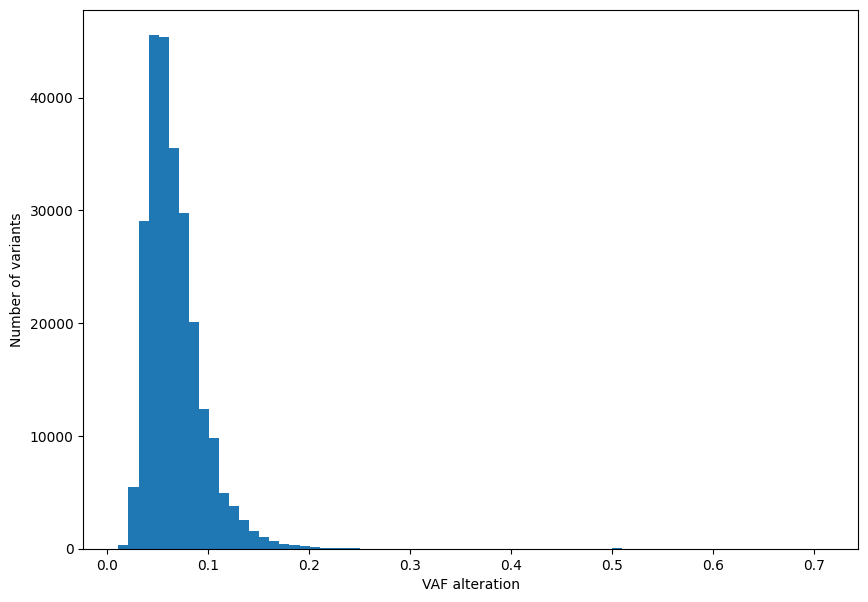

count    249588.000000
mean          0.067235
std           0.030136
min           0.011628
25%           0.047619
50%           0.061224
75%           0.080000
max           0.708333
Name: VAF_alt, dtype: float64

In [14]:
# Number of VAF variants per case
plt.figure(figsize=(10, 7))
plt.hist(maf_can_VAF_SNV['VAF_alt'],70)
plt.ylabel('Number of variants')
plt.xlabel('VAF alteration')
plt.show()
maf_can_VAF_SNV['VAF_alt'].describe()

In [15]:
maf_can_VAF_SNV = maf_can_VAF_SNV.astype({'POS': str, '#CHROM': str, 'REF': str, 'ALT': str, 'case': str}) 
maf_can_VAF_SNV['rep'] = maf_can_VAF_SNV['#CHROM']+':'+maf_can_VAF_SNV['POS']+','+maf_can_VAF_SNV['REF']+'/'+maf_can_VAF_SNV['ALT']
maf_can_VAF_SNV['rep2'] = maf_can_VAF_SNV['#CHROM']+':'+maf_can_VAF_SNV['POS']+','+maf_can_VAF_SNV['REF']+'/'+maf_can_VAF_SNV['ALT']+'-'+maf_can_VAF_SNV['case']  

## 4. Remove pol of normals

In [3]:
poN = pd.read_csv('polN/polN_U2AF1_v2.vcf', compression='gzip',sep="\t")
len(poN)

53

In [17]:
maf_can_VAF_SNV['poN'] = maf_can_VAF_SNV['#CHROM']+':'+maf_can_VAF_SNV['POS']+','+maf_can_VAF_SNV['REF']

In [18]:
maf_can_VAF_SNV = maf_can_VAF_SNV[~maf_can_VAF_SNV['poN'].isin(poN.rep.to_list())]
len(maf_can_VAF_SNV)

5620

In [19]:
maf_can_VAF_SNV['Occur'] = [maf_can_VAF_SNV['rep'].tolist().count(x) for x in maf_can_VAF_SNV['rep']]
len(maf_can_VAF_SNV)

5620

In [20]:
maf_can_VAF_SNV.rep.value_counts()

chr21:43094716,G/A      1330
chr21:43093194,G/C       375
chr21:43093200,G/C       288
chr21:43094663,A/C       146
chr21:43093204,T/G        94
                        ... 
chr21:43107487,T/A         1
chr21:43094561,T/C         1
chr21:43094727,C/T         1
chr21:43093196,C/A,G       1
chr21:43095695,T/C         1
Name: rep, Length: 495, dtype: int64

## 5. BoostDM prediction

In [21]:
maf_can_VAF_SNV['#CHROM'] = maf_can_VAF_SNV['#CHROM'].str.replace('chr', '')

In [3]:
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', compression='gzip',sep="\t")
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
BoostDM_dirvers

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0
20,ASXL1,20,32358785,T,4,K4*,0,1,0,0,0.989768,1,0.0,0.0,0.0,0.0
29,ASXL1,20,32358788,T,5,Q5*,0,1,0,0,0.975674,1,0.0,0.0,0.0,0.0
38,ASXL1,20,32358791,T,6,K6*,0,1,0,0,0.991413,1,0.0,0.0,0.0,0.0
47,ASXL1,20,32358794,T,7,K7*,0,1,0,0,0.988842,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87811,U2AF1,21,43104401,G,16,V16L,1,0,0,0,0.897579,1,0.0,0.0,0.0,0.0
87812,U2AF1,21,43104401,T,16,V16I,1,0,0,0,0.897579,1,0.0,0.0,0.0,0.0
87816,U2AF1,21,43107451,A,15,K15I,1,0,0,0,0.508676,1,0.0,0.0,0.0,0.0
87817,U2AF1,21,43107451,C,15,K15R,1,0,0,0,0.508676,1,0.0,0.0,0.0,0.0


In [23]:
#Select mutations based on driver call

maf_can_VAF_SNV['ID2'] = maf_can_VAF_SNV['#CHROM'].astype(str)+"-"+\
                            maf_can_VAF_SNV['POS'].astype(str) +"-"+\
                            maf_can_VAF_SNV['ALT'].astype(str)


BoostDM_dirvers['ID2'] = Rules_matrix['chr'].astype(str) +"-"+\
                            Rules_matrix['pos'].astype(str) +"-"+\
                            Rules_matrix['alt'].astype(str)

maf_can_VAF_SNV['BoostDM'] = np.where(maf_can_VAF_SNV['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
maf_can_VAF_SNV['BoostDM'].value_counts()

/tmp/ipykernel_238/4174354237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BoostDM_dirvers['ID2'] = Rules_matrix['chr'].astype(str) +"-"+\


0    5154
1     466
Name: BoostDM, dtype: int64

In [24]:
maf_can_VAF_SNV[maf_can_VAF_SNV['Prot_pos']=='157'][['Prot_pos', 'AA_change', 'Occur', 'BoostDM']]

,Prot_pos,AA_change,Occur,BoostDM
1550,157,Q/L,9,1
2083,157,Q/R,44,1
2987,157,Q/R,44,1
4267,157,Q/L,9,1
5479,157,Q/R,44,1
...,...,...,...,...
240105,157,Q/P,69,1
240622,157,Q/P,69,1
242258,157,Q/P,69,1
244947,157,Q/R,44,1


In [34]:
maf_can_VAF_SNV.to_csv("All450k_filtered_boostDM_U2AF1.vcf", sep="\t", index=False, compression='gzip')